In [17]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(132)

from scipy.optimize import minimize
'''
Exercise 3.2
This example will explore geometry and sampling probabilities in high
dimensional spaces.

(a) Consider a two dimensional square dart board with length L=2
on both sides, and a circle of radius R = 1 in the middle. Write a program to
throw 10,000 darts by generating a uniform random x and y position on the square.
Compute the radius for each point and compute what fraction land inside the circle
(i.e. how many have radius <1). Is this consistent with your expectation based on
area of the circle and the square?

(b) Repeat this experiment, throwsing 10,000 darts randomly (sampled from a uniform
distribution) on an N-dimensional cube (length L = 2) with an N-dimensional sphere
inside (radius R = 1), for N = 2 through N = 10. For a given N, what fraction
'''



'\nExercise 3.2\nThis example will explore geometry and sampling probabilities in high\ndimensional spaces.\n\n(a) Consider a two dimensional square dart board with length L=2\non both sides, and a circle of radius R = 1 in the middle. Write a program to\nthrow 10,000 darts by generating a uniform random x and y position on the square.\nCompute the radius for each point and compute what fraction land inside the circle\n(i.e. how many have radius <1). Is this consistent with your expectation based on\narea of the circle and the square?\n\n(b) Repeat this experiment, throwsing 10,000 darts randomly (sampled from a uniform\ndistribution) on an N-dimensional cube (length L = 2) with an N-dimensional sphere\ninside (radius R = 1), for N = 2 through N = 10. For a given N, what fraction\n'

fraction inside the circle is 0.7889 %


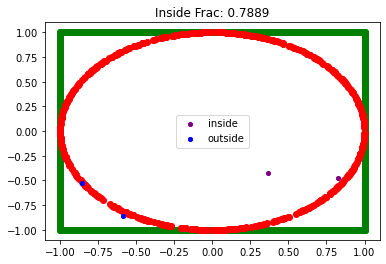

This is a bit counterintutive to me given that any value within the given interval should be equally likely to be selected. It appears about 99% of the samples lie between the circle and the square.


In [12]:

def generate_square(x_cen, y_cen, n, L=2.0):
    s = L/2.0
    X = np.linspace(x_cen-s, x_cen+s, n)

    X1,X2 = np.meshgrid(X,np.array([-1.0,1.0]))
    X = np.concatenate((X1, X2), axis = 0)
    Y = np.concatenate((X2, X1), axis = 0)

    return X, Y

def generate_circle(n, r=1.0):
    two_pi = 2.0 * np.pi
    theta = np.random.uniform(0, 2*np.pi, (n,1))
    #np.linspace(0, two_pi, n)[:-1][None,:]
    x = r*np.cos(theta)
    y = r*np.sin(theta)

    return x,y

samp_max = 1.0
samp_min = -1.0
NN = 10000

#Generating square and circle data to plot
xc,yc = generate_circle(600,1.0)
xs,ys = generate_square(0.0,0.0, 500)

'''dart_x = np.random.uniform(samp_min, samp_max, N)
dart_y = np.random.uniform(samp_min, samp_max, N)
darts = np.array([dar_x, dar_y])'''

darts = np.zeros((2,NN))
darts[0,:] = np.random.uniform(samp_min, samp_max, NN)
darts[1,:] = np.random.uniform(samp_min, samp_max, NN)
rads = np.zeros((NN,1))

within = 0
inside = []
outside = []
for i in range(NN):
    x=darts[0,i]
    y=darts[1,i]
    r = np.sqrt((x**2) + (y**2))
    rads[i] = r

    if r <=1:
        within+=1
        inside.append(darts[:,i])
    else:
        #print(darts[:,i])
        outside.append(darts[:,i])

inside = np.array(inside)
outside = np.array(outside)

print('fraction inside the circle is '+str(within/NN)+' %')

plt.figure()
plt.scatter(xs,ys,color='green')
plt.scatter(xc,yc,color='red')
plt.scatter(inside[0,:],inside[1,:],color='purple',s=17.0,label='inside')
plt.scatter(outside[0,:],outside[1,:],color='blue',s=17.0,label='outside')
plt.title('Inside Frac: '+str(within/NN))
plt.legend()
plt.show()

print('This is a bit counterintutive to me given that any value within the given interval should be equally likely to be selected. It appears about 99% of the samples lie between the circle and the square.')


In [19]:
'''
Exercise 3.3

This exercise will explore the relationship between the sparsity K, the signal
size n, and the number of samples p in compressed sensing

- For n=1000, and K=5, create a K-sparse vectors of Fourier coefficients in a
Fourier basis Psi.
- For each p from 1 to 100, create a Gaussian random sampling matrix
C in R^{pxn} to create a measurement vector y = C P_si s.
Use compressed sensing based on this measurement to estimate s_hat.
For each p, repeat this with at least 10 realization of the random measurement matrix C.
- Plot the average relative error ||s_hat - s||_2 / ||s||_2 versus p; it may be
helpful to visualize the errors with a box-and-whisker plot. Explain the trends.
Also plot the average l_1, l_0 error versus p.
- Repeat the above experiment for K =1 through K = 20. What are the changes?
- Now repeat the above experiment for K = 5, varying the signal size using n=100,
n=500, n=1000, n=2000, and n=5000
'''
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

def run_compressed_sensing(s, Psi, P):
    L2_errors = np.zeros((P,10))
    L1_errors = np.zeros((P,10))
    L0_errors = np.zeros((P,10))

    for p in range(P):

        for i in range(0,10):
            C = np.random.normal(loc=0.0, scale=1.0, size=(p+1,n))
            Theta = np.real(C @ Psi)
            y = Theta @ s

            constr = ({'type': 'eq', 'fun': lambda x: Theta @ x - y})
            x0 = np.linalg.pinv(Theta) @ y

            res1 = minimize(L1_norm, x0, method = 'SLSQP', constraints=constr)
            s_L1 = res1.x


            L2_errors[p,i] = np.linalg.norm(s_L1 - s, ord=2)/ np.linalg.norm(s, ord=2)
            L1_errors[p,i] = np.linalg.norm(s_L1 - s, ord=1)/ np.linalg.norm(s, ord=1)
            L0_errors[p,i] = np.linalg.norm(s_L1 - s, ord=0)/ np.linalg.norm(s, ord=0)

    return L2_errors, L1_errors, L0_errors

def create_ksparse(K,Psi,n):
    #Creating fourier coefficients matrix that will be k sparse (composed of only K basis vectors)
    s = np.zeros((n,))
    kindx = np.random.permutation(n)[:K]
    #print(kindx)
    s[kindx] = 1.0
    x = Psi @ s # X
    s = np.real(Psi @ x)#np.linalg.inv(Psi)@x
    return s


In [ ]:
n=1000
K=5
P = 100
#Generate basis Psi
Psi = np.fft.fft(np.eye(n)) #dft matrix
s = create_ksparse(K,Psi,n)

'''plt.figure()
plt.plot(s)
plt.show()'''

L2_errors, L1_errors, L0_errors = run_compressed_sensing(s, Psi, P)

L2_avgs = np.mean(L2_errors, axis=-1)
L1_avgs = np.mean(L1_errors, axis=-1)
L0_avgs = np.mean(L0_errors, axis=-1)

p_list = list(range(1, P))
p_list = np.array(p_list)


print(p_list.shape)
print(L2_avgs.shape)

plt.figure()
plt.plot(p_list, L2_avgs, color='b', label='L2 avgs')
plt.plot(p_list, L1_avgs, color='g', label='L1 avgs')
plt.plot(p_list, L0_avgs, color='r', label='L0 avgs')
plt.legend()
#plt.show()

In [ ]:
'''
for k in range(20):
    s = create_ksparse(k+1,Psi,n)

    L2_errors, L1_errors, L0_errors = run_compressed_sensing(s, Psi, P)

    L2_avg = np.mean(L2_errors, axis=-1)
    L1_avg = np.mean(L1_errors, axis=-1)
    L0_avg = np.mean(L0_errors, axis=-1)

    p_list = list(range(1, P))
    p_list = np.array(p_list)


    plt.figure()
    plt.plot(p_list, L2_avg,color='b', label='L2 avgs')
    plt.plot(p_list, L1_avg,color='g', label='L1 avgs')
    plt.plot(p_list, L0_avg,color='r', label='L0 avgs')
    plt.legend()
    #plt.show()

K=5
for nn in [100, 500, 1000, 2000, 5000]:
    s = create_ksparse(K,Psi,nn)

    L2_errors, L1_errors, L0_errors = run_compressed_sensing(s, Psi, P)

    L2_avg = np.mean(L2_errors, axis=-1)
    L1_avg = np.mean(L1_errors, axis=-1)
    L0_avg = np.mean(L0_errors, axis=-1)

    p_list = list(range(1, P))
    p_list = np.array(p_list)


    plt.figure()
    plt.plot(p_list, L2_avg,color'='b', label='L2 avgs')
    plt.plot(p_list, L1_avg,color'='g', label='L1 avgs')
    plt.plot(p_list, L0_avg,color'='r', label='L0 avgs')
    plt.legend()

'''